In [18]:
import os, sys, time, pickle
from pathlib import Path
from collections import Counter
from IPython.display import Audio


PROJECT_DIR = Path(sys.path[0])/".."
DATA_DIR = PROJECT_DIR/"data"
SRC_DIR = PROJECT_DIR/"src"
DEPS_DIR = PROJECT_DIR/"deps"

sys.path.append(str(SRC_DIR))
sys.path.append(str(DEPS_DIR))

%pylab inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pandas as pd
import torch, torchaudio
from torchaudio import transforms
import torchaudio.functional as F
import torchaudio.transforms as T

from audio_lib import Mp3Stream

In [3]:
DATA_DIR = "/home/keld/projects/music_gen/sc_scrape/data/"

archive_tracker_path = "/d16Tb/soundcloud_music/archive_tracker"
out_path = "/d16Tb/soundcloud_music/files/"    

data_obj_path = f"{DATA_DIR}sc_data_v2.pckl"

In [4]:
all_music_info_df = pd.read_csv(f"{DATA_DIR}music_info.tsv.gz", compression='gzip', sep='\t', low_memory=False)

In [5]:
top50_genre_samples_df = pd.read_csv("/n1Tb/sc_mp3_top50_genre_samples.tsv_gz", compression='gzip', sep='\t')

In [6]:
top50_genre_samples_df.columns

Index(['Unnamed: 0', 'album', 'albumartist', 'artist', 'audio_offset',
       'bitrate', 'channels', 'composer', 'disc', 'disc_total', 'duration',
       'filesize', 'genre', 'samplerate', 'title', 'track', 'track_total',
       'year', 'local_path', 'sc_user', 'sc_track_name', 'sc_link', 'tag',
       'likes', 'reposts', 'plays', 'comments', 'nvme_fp'],
      dtype='object')

In [7]:
top50_genre_samples_df[["nvme_fp", "genre"]]

nvme_fp     genre
0      /n1Tb/sc_mp3_top50_genre_samples/Mood Cake (ch...       edm
1      /n1Tb/sc_mp3_top50_genre_samples/Obelisk_2_Obe...       edm
2      /n1Tb/sc_mp3_top50_genre_samples/Arbetter - Ja...       edm
3      /n1Tb/sc_mp3_top50_genre_samples/Hellberg & Te...       edm
4      /n1Tb/sc_mp3_top50_genre_samples/[RCKBTM042] F...       edm
...                                                  ...       ...
49995  /n1Tb/sc_mp3_top50_genre_samples/Daddy's Money...  nu disco
49996  /n1Tb/sc_mp3_top50_genre_samples/Walking In Th...  nu disco
49997    /n1Tb/sc_mp3_top50_genre_samples/MiM - RIZE.mp3  nu disco
49998  /n1Tb/sc_mp3_top50_genre_samples/Rick James - ...  nu disco
49999  /n1Tb/sc_mp3_top50_genre_samples/My Sharona by...  nu disco

[50000 rows x 2 columns]

In [8]:
#Mp3Stream(top50_genre_samples_df.iloc[10]["nvme_fp"]).play()

In [9]:
idx = 11
song = Mp3Stream(top50_genre_samples_df.iloc[idx]["nvme_fp"])
meta = top50_genre_samples_df.iloc[11]

In [13]:
song.play(1)

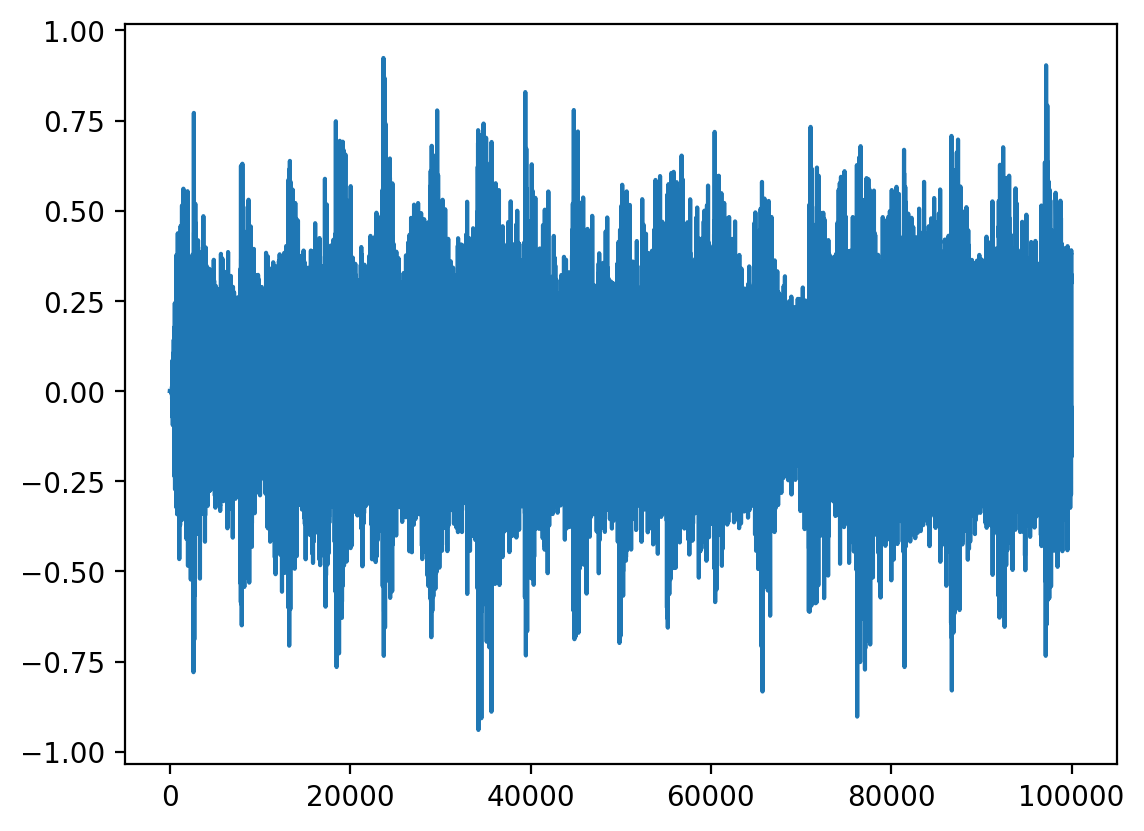

In [19]:
from audio_lib import Mp3Stream 

idx = 12
song_info =  top50_genre_samples_df.iloc[idx]
song = Mp3Stream(song_info["nvme_fp"])
plt.plot(song.np_decode_rand_offset(1e5).transpose()[0,:100000]);

In [24]:
Audio(song.np_decode_rand_offset(1e5).transpose()[:,1000:100000], rate=44100)

Shows that the first ~250 samples are always ~0! 

### data play

In [23]:
data = song.np_decode(1e6)

In [25]:
f"{data.nbytes:,d}"

'21,362,688'

In [26]:
data = song.np_decode(200000, int(1e5))

In [31]:
%%timeit -n 1 -r 1
torch.tensor(data)

353 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [33]:
%%timeit -n 1 -r 1
data = torch.tensor(song.np_decode(100000, int(1e5)))

10.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


There isn't any overhead on converting from numpy to torch so will do it outside

In [35]:
data = torch.tensor(song.np_decode(100000, int(1e5)))

In [36]:
data.dtype

torch.float32

### fft

In [73]:
song = Mp3Stream(top50_genre_samples_df.iloc[11]["nvme_fp"])

In [76]:
t_data = torch.tensor(song.np_decode()) 

In [77]:
t_data.shape

torch.Size([8951040, 2])

In [78]:
spectrogram_transform = transforms.Spectrogram(n_fft=1024)

In [80]:
spectrogram = spectrogram_transform(t_data[:, 0])
melscale_transform = transforms.MelScale(sample_rate=song.sample_rate, n_stft=1024 // 2 + 1)
melscale_spectrogram = melscale_transform(spectrogram)

/home/keld/miniconda3/envs/mugen_ml/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [51]:
melscale_spectrogram

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.7226e+00, 3.6897e+02, 5.4222e+02,  ..., 4.0157e+01, 4.7169e+01,
         5.7358e+01],
        [4.5838e-01, 9.8180e+01, 1.4428e+02,  ..., 1.0685e+01, 1.2551e+01,
         1.5262e+01],
        ...,
        [2.9045e-07, 2.8071e-07, 4.5142e-07,  ..., 3.8127e-07, 2.6254e-07,
         3.3143e-04],
        [4.4226e-07, 6.4367e-07, 2.7310e-07,  ..., 5.0309e-07, 5.1942e-07,
         3.2945e-04],
        [4.5189e-07, 2.3521e-07, 2.9858e-07,  ..., 2.5377e-07, 5.8790e-07,
         3.4734e-04]])

In [83]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 1024
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=song.sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)



In [84]:
%%timeit -n 1 -r 1
mfcc = mfcc_transform(t_data[:,0])

178 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [82]:
mfcc.shape

torch.Size([256, 17483])

/tmp/ipykernel_59618/1878930876.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=128).
  plt.specgram(melscale_spectrogram, Fs=song.sample_rate);


Text(0, 0.5, 'Frequency')

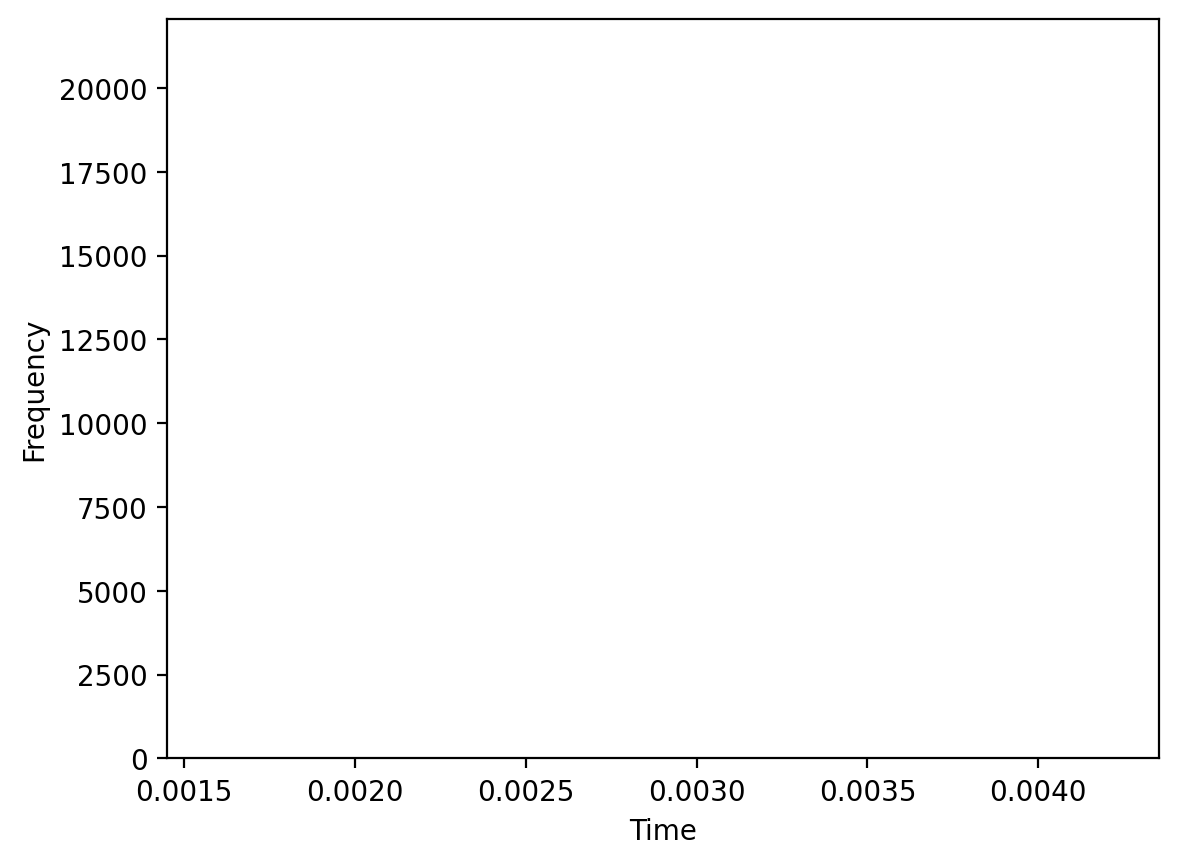

In [55]:
plt.specgram(melscale_spectrogram, Fs=song.sample_rate);
plt.xlabel('Time');
plt.ylabel('Frequency');

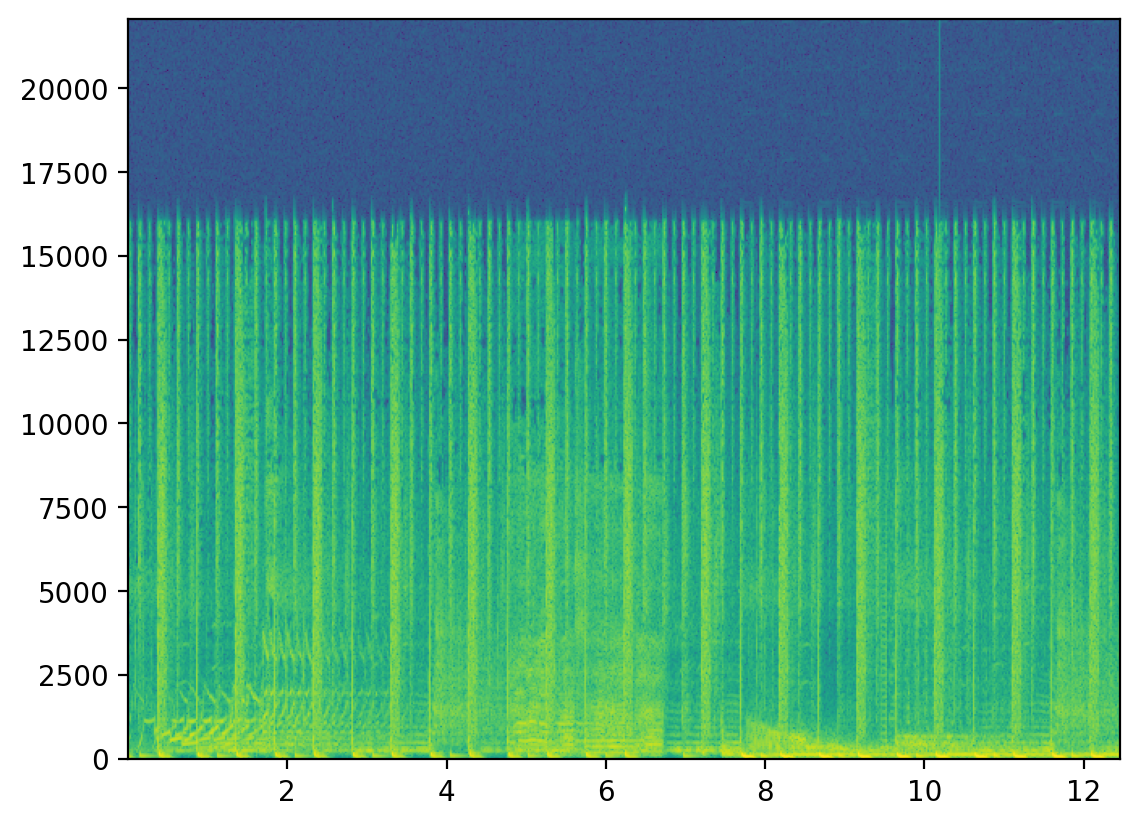

In [61]:
plt.specgram(waveform, NFFT=1024, Fs=song.sample_rate);

In [ ]:
class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=8000,
        n_fft=1024,
        n_mel=256,
        stretch_factor=0.8,
    ):
        super().__init__()
        self.resample = Resample(orig_freq=input_freq, new_freq=resample_freq)

        self.spec = Spectrogram(n_fft=n_fft, power=2)

        self.spec_aug = torch.nn.Sequential(
            TimeStretch(stretch_factor, fixed_rate=True),
            FrequencyMasking(freq_mask_param=80),
            TimeMasking(time_mask_param=80),
        )

        self.mel_scale = MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample the input
        resampled = self.resample(waveform)

        # Convert to power spectrogram
        spec = self.spec(resampled)

        # Apply SpecAugment
        spec = self.spec_aug(spec)

        # Convert to mel-scale
        mel = self.mel_scale(spec)

        return mel

In [ ]:
plt.specgram(waveform, NFFT=1024, Fs=song.sample_rate);

In [66]:
transform = transforms.MelSpectrogram(song.sample_rate, n_fft=1024, n_mels=256)


In [67]:
mel_specgram = transform(waveform)

In [69]:
mel_specgram.shape

torch.Size([256, 1074])

In [ ]:
waveform

In [ ]:
pipeline.to(device=torch.device("cuda"), dtype=torch.float32)


In [73]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

In [71]:
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

In [ ]:
waveform

In [ ]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

In [72]:
spec = spectrogram(waveform)


NameError: name 'librosa' is not defined

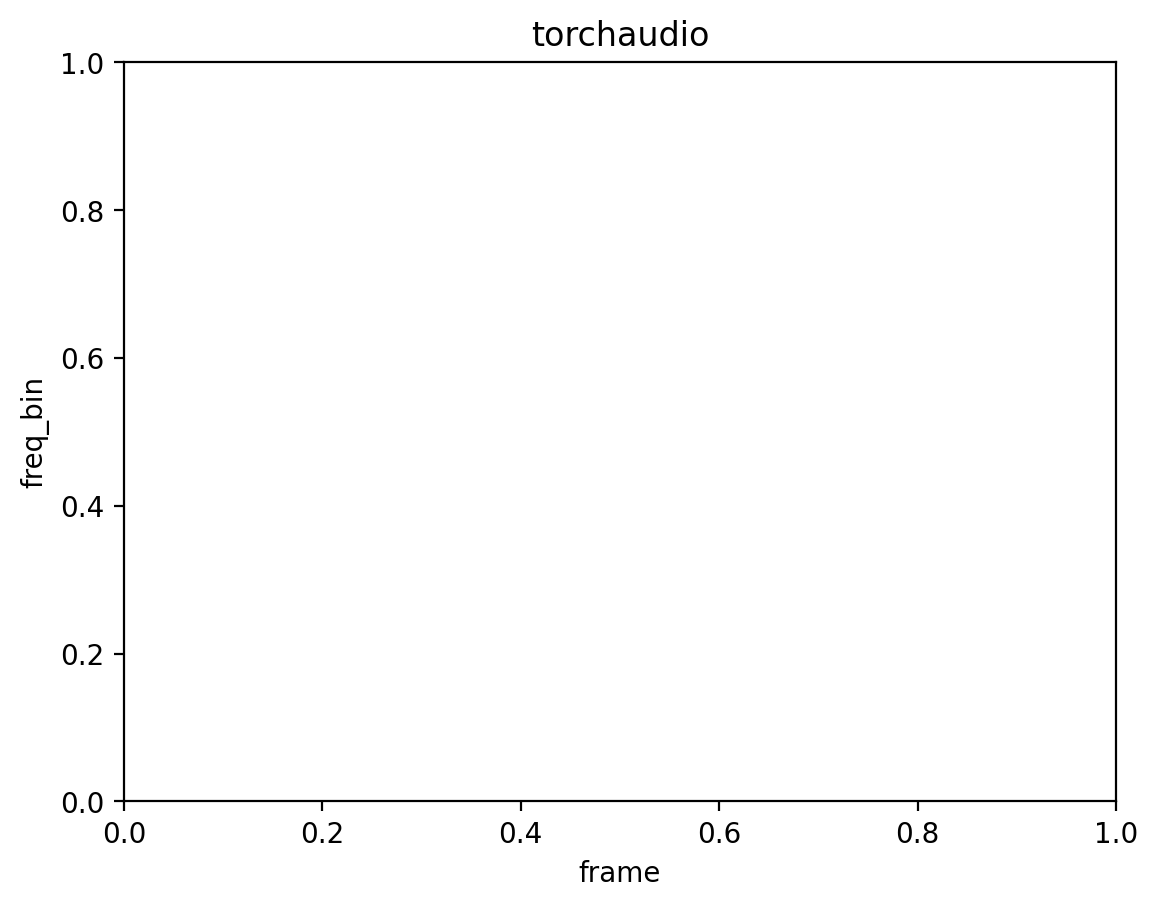

In [74]:
plot_spectrogram(spec[0], title="torchaudio")
